In [1]:
from functools import partial

import IPython
import torch.distributions
import transformer_lens
from transformer_lens import HookedTransformer
from IPython.display import SVG

import core

%load_ext autoreload
%autoreload 2

In [2]:
model = HookedTransformer.from_pretrained("gpt2-small")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
model = HookedTransformer.from_pretrained("attn-only-4l")

Loaded pretrained model attn-only-4l into HookedTransformer


# IOI task

In [27]:
threshold = 0.3
prompt = "When Mary and John went to the store, John gave a book to"
corrupt_prompt = "When Tom and Sarah went to the store, Felix gave a book to"
c = core.connectom(model, prompt,
                   core.logit_diff_metric(model, ' Mary', ' John'),
                   core.ZeroPattern(),
                   # core.CorruptIntervention(model, prompt, corrupt_prompt),
                   # core.CropIntervention(model, prompt),

                   core.BasicStrategy(),
                   # d.BacktrackBisectStrategy(threshold),
                   # d.BacktrackingStrategy(threshold),
                   # core.BisectStrategy(threshold),
                   # core.SplitStrategy(model, prompt, threshold),
                   )
core.plot_attn_connectome(model, prompt, c).show()
# graph = core.plot_graphviz_connectome(model, prompt, c, threshold=threshold).pipe('svg').decode('utf-8')
# SVG(graph)


Baseline strength: -0.12


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

In [ ]:
graph = core.plot_graphviz_connectome(model, prompt, c, threshold=0.2).pipe('svg').decode('utf-8')
SVG(graph)

# Docstring task

In [28]:
model = HookedTransformer.from_pretrained("attn-only-4l")
threshold = 0.3
prompt = '''def port(self, load, size, file, last):
    """oil column piece

    :param load: crime population
    :param size: unit dark
    :param'''
corrupt_prompt = prompt.replace("load", "banana").replace("size", "apple").replace("file", "pear").replace("last", "orange")

c = core.connectom(model, prompt,
                   core.logit_diff_metric(model, ' file', ' self', ' load', ' size', ' last'),
                   core.ZeroPattern(),
                   # core.CorruptIntervention(model, prompt, corrupt_prompt),

                   # core.BasicStrategy(),
                   core.SplitStrategy(model, prompt, threshold),
                   # core.BacktrackBisectStrategy(threshold),
                   # d.BacktrackingStrategy(threshold),
                   # core.BisectStrategy(threshold),
                   )

Loaded pretrained model attn-only-4l into HookedTransformer
Baseline strength: 5.41


Exploring: 0 connexions [00:00, ? connexions/s]

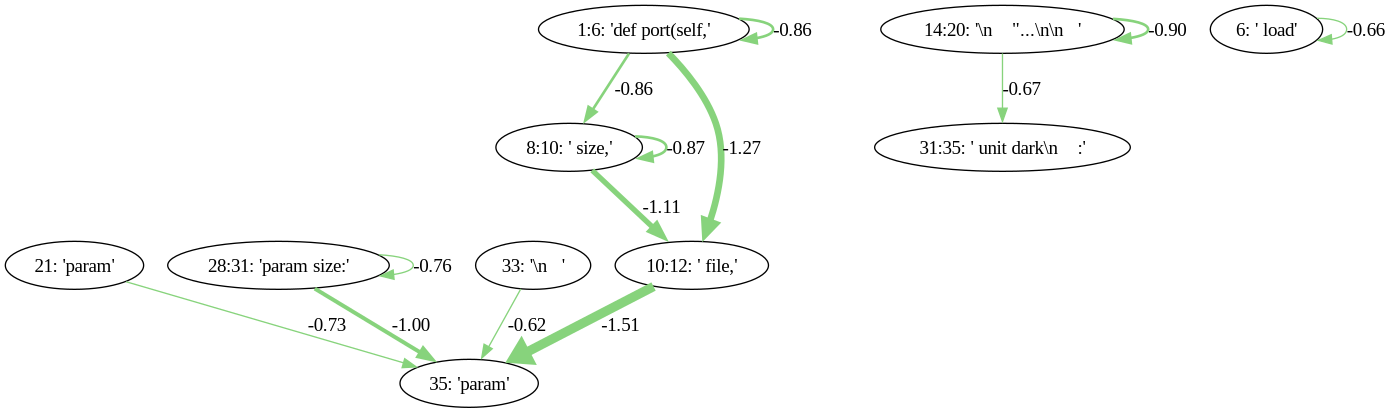

In [40]:
graph_threshold = 0.6
core.plot_attn_connectome(model, prompt, c).show()
# graph = core.plot_graphviz_connectome(model, prompt, c, graph_threshold, depth=2).pipe('svg').decode('utf-8')
graph = core.plot_graphviz_connectome(model, prompt, c, graph_threshold, depth=2).pipe('png')
import IPython
IPython.display.Image(graph)
# SVG(graph)


In [ ]:
print(prompt)
transformer_lens.utils.test_prompt(prompt, ' file', model)

# Code task on Pythia

In [46]:
model = HookedTransformer.from_pretrained('gpt2-medium')

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer


In [45]:
prompt = """from typing import List, Dict
def f(x: List):
    return sum(x[::2])

def g(x: float):
    return x ** 2

def h(x: Dict):
    return sum(x.values())

def i(x: str):
    return len(x)

var1: str = 'abc'
var2: Dict = {'a': 1, 'b': 2}
var3: List = [1, 2, 3]
var4: int = 4

h(var"""

transformer_lens.utils.test_prompt(prompt, '1', model)


Tokenized prompt: ['<|endoftext|>', 'from', ' typing', ' import', ' List', ',', ' D', 'ict', '\n', 'def', ' f', '(', 'x', ':', ' List', '):', '\n', ' ', ' ', ' ', ' return', ' sum', '(', 'x', '[', '::', '2', '])', '\n', '\n', 'def', ' g', '(', 'x', ':', ' float', '):', '\n', ' ', ' ', ' ', ' return', ' x', ' **', ' 2', '\n', '\n', 'def', ' h', '(', 'x', ':', ' D', 'ict', '):', '\n', ' ', ' ', ' ', ' return', ' sum', '(', 'x', '.', 'values', '())', '\n', '\n', 'def', ' i', '(', 'x', ':', ' str', '):', '\n', ' ', ' ', ' ', ' return', ' len', '(', 'x', ')', '\n', '\n', 'var', '1', ':', ' str', ' =', " '", 'abc', "'", '\n', 'var', '2', ':', ' D', 'ict', ' =', ' {', "'", 'a', "':", ' 1', ',', " '", 'b', "':", ' 2', '}', '\n', 'var', '3', ':', ' List', ' =', ' [', '1', ',', ' 2', ',', ' 3', ']', '\n', 'var', '4', ':', ' int', ' =', ' 4', '\n', '\n', 'h', '(', 'var']
Tokenized answer: [' 1']


Performance on answer token:
Rank: 20       Logit: 11.51 Prob:  0.03% Token: | 1|

Top 0th token. Logit: 19.21 Prob: 70.42% Token: |1|
Top 1th token. Logit: 17.25 Prob:  9.88% Token: |3|
Top 2th token. Logit: 17.06 Prob:  8.19% Token: |4|
Top 3th token. Logit: 16.55 Prob:  4.91% Token: |2|
Top 4th token. Logit: 16.18 Prob:  3.39% Token: |5|
Top 5th token. Logit: 14.41 Prob:  0.58% Token: |0|
Top 6th token. Logit: 14.15 Prob:  0.45% Token: |,|
Top 7th token. Logit: 13.39 Prob:  0.21% Token: |:|
Top 8th token. Logit: 13.23 Prob:  0.18% Token: |)|
Top 9th token. Logit: 13.06 Prob:  0.15% Token: |.|


Ranks of the answer tokens: [(' 1', 20)]

# Exploration of grouping techniques

In [ ]:
# Finding the log-probs on the prompt tokens
prompt = "When Mary and John went to the store, John gave a book to Mary."
log_probs = model(prompt)[0].log_softmax(-1)  # (seq_len, vocab_size)
tokens = model.to_tokens(prompt)[0]
tokens_str = model.to_str_tokens(tokens)
print(tokens.shape)
print(log_probs.shape)
correct_logprobs = log_probs[torch.arange(len(tokens) - 1), tokens[1:]]
print(correct_logprobs.shape)
for i, (t, n, l) in enumerate(zip(tokens_str, tokens_str[1:], correct_logprobs)):
    print(f"{i:2d} {t!r} {l.item():.2f} -> {n!r}")

import plotly.express as px
px.line(x=[f'{i} {t!r} -> {n!r}' for i, (t, n) in enumerate(zip(tokens_str, tokens_str[1:]))],
        y=correct_logprobs.detach() * 0)

In [ ]:
prompt = '''def port(self, load, size, file, last):
    """oil column piece

    :param load: crime population
    :param size: unit dark
    :param'''

print(prompt)
s = core.SplitStrategy(model, prompt, 0.1,
                       (
                           '\n\n',
                           tuple('.!?'),
                           tuple(',:;'),
                       )
                       )
s.show_tree()

In [24]:
len(core.filter_connectome(c, 1))

[<Connexion(1:36 -> 1:36: -1.73)>, <Connexion(1:20 -> 1:20: -0.89)>, <Connexion(1:20 -> 20:36: -0.83)>, <Connexion(20:36 -> 20:36: -1.42)>, <Connexion(14:20 -> 14:20: -0.90)>, <Connexion(1:6 -> 14:20: -0.11)>, <Connexion(1:6 -> 1:6: -0.86)>, <Connexion(14:20 -> 24:28: -0.18)>, <Connexion(14:20 -> 31:35: -0.67)>, <Connexion(1:6 -> 24:28: -0.22)>]
<Connexion(1:36 -> 1:36: -1.73)> to None
<Connexion(1:20 -> 1:20: -0.89)> to <Connexion(1:36 -> 1:36: -1.73)>
<Connexion(1:20 -> 20:36: -0.83)> to <Connexion(1:36 -> 1:36: -1.73)>
<Connexion(20:36 -> 20:36: -1.42)> to <Connexion(1:36 -> 1:36: -1.73)>
<Connexion(14:20 -> 14:20: -0.90)> to <Connexion(1:20 -> 1:20: -0.89)>
<Connexion(1:6 -> 14:20: -0.11)> to <Connexion(1:20 -> 1:20: -0.89)>
<Connexion(1:6 -> 1:6: -0.86)> to <Connexion(1:20 -> 1:20: -0.89)>
<Connexion(14:20 -> 24:28: -0.18)> to <Connexion(1:20 -> 20:36: -0.83)>
<Connexion(14:20 -> 31:35: -0.67)> to <Connexion(1:20 -> 20:36: -0.83)>
<Connexion(1:6 -> 24:28: -0.22)> to <Connexion(1:2

3

In [21]:
len(c)

297